In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy.random as npr

import sys
import os
core_dir = os.path.join(os.getcwd(), '../..', 'nomad')
core_dir = os.path.normpath(core_dir)
sys.path.append(core_dir)

import city_gen as cg
from city_gen import City, Building, Street
import traj_gen as tg
from traj_gen import Agent, Population
import stop_detection as sd
from constants import DEFAULT_SPEEDS, FAST_SPEEDS, SLOW_SPEEDS, DEFAULT_STILL_PROBS
from constants import FAST_STILL_PROBS, SLOW_STILL_PROBS, ALLOWED_BUILDINGS

import pdb

In [2]:
city = cg.load('garden-city.pkl')
population = Population(city)
os.environ['TZ'] = 'UTC'

In [3]:
Bob = Agent("Bob",
            'h-x8-y8',
            'w-x18-y4',
            city,
            start_time=datetime(2024, 1, 1, hour=7, minute=0))

population.add_agent(Bob)
population.generate_trajectory(Bob, T=datetime(2024, 1, 1, hour=19, minute=0))

print(Bob.diary)
print(Bob.trajectory)

    unix_timestamp     local_timestamp  duration   location
0       1704092400 2024-01-01 07:00:00        61    h-x8-y8
1       1704096060 2024-01-01 08:01:00         7       None
2       1704096480 2024-01-01 08:08:00       233   w-x18-y4
3       1704110460 2024-01-01 12:01:00         6       None
4       1704110820 2024-01-01 12:07:00         9    r-x3-y6
5       1704111360 2024-01-01 12:16:00         1       None
6       1704111420 2024-01-01 12:17:00        14    r-x3-y5
7       1704112260 2024-01-01 12:31:00         1       None
8       1704112320 2024-01-01 12:32:00        14    r-x3-y6
9       1704113160 2024-01-01 12:46:00         2       None
10      1704113280 2024-01-01 12:48:00        43    r-x3-y8
11      1704115860 2024-01-01 13:31:00         9       None
12      1704116400 2024-01-01 13:40:00         6  r-x18-y10
13      1704116760 2024-01-01 13:46:00         8       None
14      1704117240 2024-01-01 13:54:00         7    r-x3-y6
15      1704117660 2024-01-01 14:01:00  

In [4]:
# custom version to generate the next plot

def sample_hier_nhpp(traj, beta_start, beta_durations, beta_ping, dt=1, nu=1/4, seed=0):
    npr.seed(seed)

    # Adjust beta's to account for time step
    beta_start = beta_start / dt
    beta_durations = beta_durations / dt
    beta_ping = beta_ping / dt

    # Sample starting points of bursts
    inter_arrival_times = npr.exponential(scale=beta_start, size=len(traj))
    burst_start_points = np.cumsum(inter_arrival_times).astype(int)
    burst_start_points = burst_start_points[burst_start_points < len(traj)]

    # Sample durations of each burst
    burst_durations = np.random.exponential(scale=beta_durations, size=len(burst_start_points)).astype(int)

    # Create start_points and end_points
    burst_end_points = burst_start_points + burst_durations
    burst_end_points = np.minimum(burst_end_points, len(traj) - 1)

    # Adjust end_points to handle overlaps
    for i in range(len(burst_start_points) - 1):
        if burst_end_points[i] > burst_start_points[i + 1]:
            burst_end_points[i] = burst_start_points[i + 1]

    burst_info = pd.DataFrame(columns=['start_time', 'end_time'])

    # Sample pings within each burst
    sampled_trajectories = []
    burst_info = []
    for start, end in zip(burst_start_points, burst_end_points):
        start_time = traj.iloc[start]['local_timestamp']
        end_time = traj.iloc[end]['local_timestamp']
        entry = {'start_time': start_time,
                 'end_time': end_time}
        burst_info.append(entry)

        burst_indices = np.arange(start, end)

        if len(burst_indices) == 0:
            continue

        ping_intervals = np.random.exponential(scale=beta_ping, size=len(burst_indices))
        ping_times = np.unique(np.cumsum(ping_intervals).astype(int))
        ping_times = ping_times[ping_times < (end - start)] + start

        if len(ping_times) == 0:
            continue

        burst_data = traj.iloc[ping_times].copy()
        burst_data['first_ping'] = 0
        if not burst_data.empty:
            burst_data.iloc[0, burst_data.columns.get_loc('first_ping')] = 1

        sampled_trajectories.append(burst_data)

    if sampled_trajectories:
        sampled_traj = pd.concat(sampled_trajectories).sort_values(by='unix_timestamp')
    else:  # empty
        sampled_traj = pd.DataFrame(columns=list(traj.columns))

    burst_info = pd.DataFrame(burst_info)

    sampled_traj = sampled_traj.drop_duplicates('local_timestamp')

    return sampled_traj, burst_info

In [5]:
Bob = Agent("Bob",
            'h-x8-y8',
            'w-x18-y4',
            city,
            start_time=datetime(2024, 1, 1, hour=7, minute=0))

population.add_agent(Bob)
population.generate_trajectory(Bob,
                               T=datetime(2024, 1, 1, hour=19, minute=0))

print(Bob.diary)
print(Bob.trajectory)

Agent identifier already exists in population. Replacing corresponding agent.
    unix_timestamp     local_timestamp  duration   location
0       1704110400 2024-01-01 07:00:00        61    h-x8-y8
1       1704114060 2024-01-01 13:01:00         7       None
2       1704114480 2024-01-01 13:08:00       233   w-x18-y4
3       1704128460 2024-01-01 17:01:00         6       None
4       1704128820 2024-01-01 17:07:00         9    r-x3-y6
5       1704129360 2024-01-01 17:16:00         1       None
6       1704129420 2024-01-01 17:17:00        14    r-x3-y5
7       1704130260 2024-01-01 17:31:00         1       None
8       1704130320 2024-01-01 17:32:00        14    r-x3-y6
9       1704131160 2024-01-01 17:46:00         2       None
10      1704131280 2024-01-01 17:48:00        43    r-x3-y8
11      1704133860 2024-01-01 18:31:00         9       None
12      1704134400 2024-01-01 18:40:00         6  r-x18-y10
13      1704134760 2024-01-01 18:46:00         8       None
14      1704135240 202

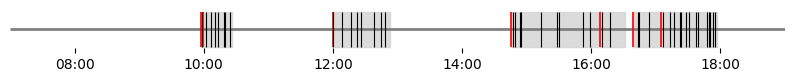

In [ ]:
Bob.sparse_traj, burst_info = sample_hier_nhpp(Bob.trajectory, 120, 30, 5, seed=10)

fig, ax = plt.subplots(figsize=(10, 0.5))

ax.hlines(1, pd.Timestamp('2024-01-01 7:00'), pd.Timestamp('2024-01-01 19:00'), color='gray', linewidth=2)

ax.vlines(burst_info['start_time'], 0.95, 1.05, color='red', linewidth=1.2, alpha=1)

for i, row in burst_info.iterrows():
    ax.fill_betweenx(
        [0.95, 1.05],
        row['start_time'],
        row['end_time'],
        color='lightgrey',
        alpha=0.8,
        zorder=1
    )

ax.vlines(Bob.sparse_traj['local_timestamp'], 0.95, 1.05, color='black', linewidth=0.8, alpha=1)

ax.set_xlim(pd.Timestamp('2024-01-01 07:00'), pd.Timestamp('2024-01-01 19:00'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=0)

[spine.set_visible(False) for spine in ax.spines.values()]
ax.yaxis.set_visible(False)

fig.savefig("nhpp-sampling.png")

plt.show()